In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

In [43]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.16.1


In [44]:
# Load numpy array
data_path = './AP_data/age_data_images_100_100.pickle'
data = np.load(data_path, allow_pickle=True)
df = pd.DataFrame(data)

In [45]:
# Ensure the 'age' column exists
if 'age' not in df.columns:
    raise ValueError("Error: 'age' column not found in the dataset.")

In [47]:
# Prepare data
X = df.drop('age', axis=1).values
y = df['age'].values

# Reshape X to 4D tensor for CNN
X = X.reshape(X.shape[0], 100, 100, 1).astype('float32')

# Normalize the data
X /= 255.0


print(X.shape, y.shape)

(9778, 100, 100, 1) (9778,)


In [48]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(7822, 100, 100, 1) (1956, 100, 100, 1) (7822,) (1956,)


In [49]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


In [51]:
# Build the CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))  # Regression output
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
    return model

input_shape = (100, 100, 1)
model = create_cnn_model(input_shape)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,369,985 (12.86 MB)

 Trainable params: 3,369,985 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * 0.1
    return lr

callbacks = [LearningRateScheduler(lr_scheduler)]


In [58]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    validation_data=(x_test, y_test),
                    epochs=10,  # Increase the number of epochs
                    callbacks=callbacks)

Epoch 1/10


c:\Aafrith\Age-prediction-Model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


245/245 ━━━━━━━━━━━━━━━━━━━━ 49s 200ms/step - loss: 605.2341 - mae: 20.4920 - val_loss: 621.5858 - val_mae: 20.8340 - learning_rate: 1.0000e-22
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 51s 209ms/step - loss: 629.6505 - mae: 21.0421 - val_loss: 621.5858 - val_mae: 20.8340 - learning_rate: 1.0000e-22
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - loss: 619.8393 - mae: 20.8720 - val_loss: 621.5858 - val_mae: 20.8340 - learning_rate: 1.0000e-22
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 55s 223ms/step - loss: 615.7126 - mae: 20.8439 - val_loss: 621.5858 - val_mae: 20.8340 - learning_rate: 1.0000e-22
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 52s 211ms/step - loss: 615.3609 - mae: 20.7657 - val_loss: 621.5858 - val_mae: 20.8340 - learning_rate: 1.0000e-22
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - loss: 622.3962 - mae: 20.8974 - val_loss: 621.5858 - val_mae: 20.8340 - learning_rate: 1.0000e-22
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 54s 218ms/step - loss: 613.0051 - mae: 20

In [59]:
# Save the trained model
model.save('./AP_model/model_cnn.h5')

In [60]:
# Model Evaluation
y_pred = model.predict(x_test).flatten()

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Mean Absolute Error (MAE): 20.833978145888004
Mean Squared Error (MSE): 621.5857576746115
Root Mean Squared Error (RMSE): 24.93162164149399
R^2 Score: -2.456946609408206e-05


In [2]:
# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE Over Epochs')

plt.show()

NameError: name 'plt' is not defined

In [3]:
# Test the model by comparing real age to predicted age
i = 100
sample = np.expand_dims(x_test[i], axis=0)
prediction = model.predict(sample)
plt.imshow(x_test[i].reshape(100, 100), cmap='gray')
plt.title(f'Real Age = {y_test[i]}\nPredicted Age = {prediction[0][0]:.1f}')
plt.show()

NameError: name 'np' is not defined

In [4]:
# Print example image from the dataset with its age
plt.imshow(x_train[0].reshape(100, 100), cmap='gray')
plt.title(f'Age = {y_train[0]}')
plt.show()

NameError: name 'plt' is not defined

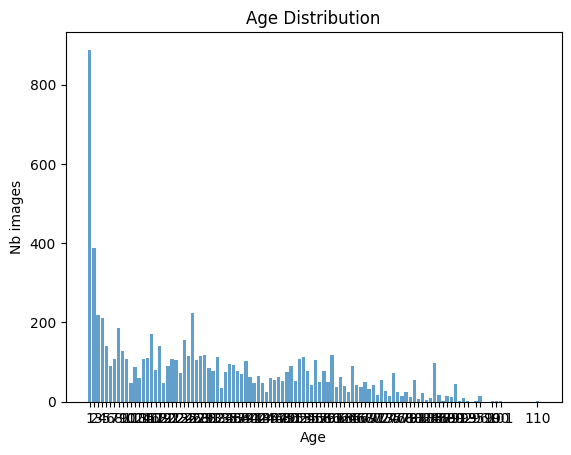

In [36]:
# Plotting age distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, align='center', alpha=0.7)
plt.xticks(unique, [str(i) for i in unique])
plt.xlabel('Age')
plt.ylabel('Nb images')
plt.title('Age Distribution')
plt.show()